<a href="https://colab.research.google.com/github/ancestor9/2025_Fall_text-image-deep-learning-with-python/blob/main/CH13_%26_CH14_Data%20windowing%20for%20deep%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/TimeSeriesForecastingInPython-master'

In [ ]:
train_df = pd.read_csv(dir_path + '/data/train.csv', index_col=0)
val_df = pd.read_csv(dir_path + '/data/val.csv', index_col=0)
test_df = pd.read_csv(dir_path + '/data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Chapter 13

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

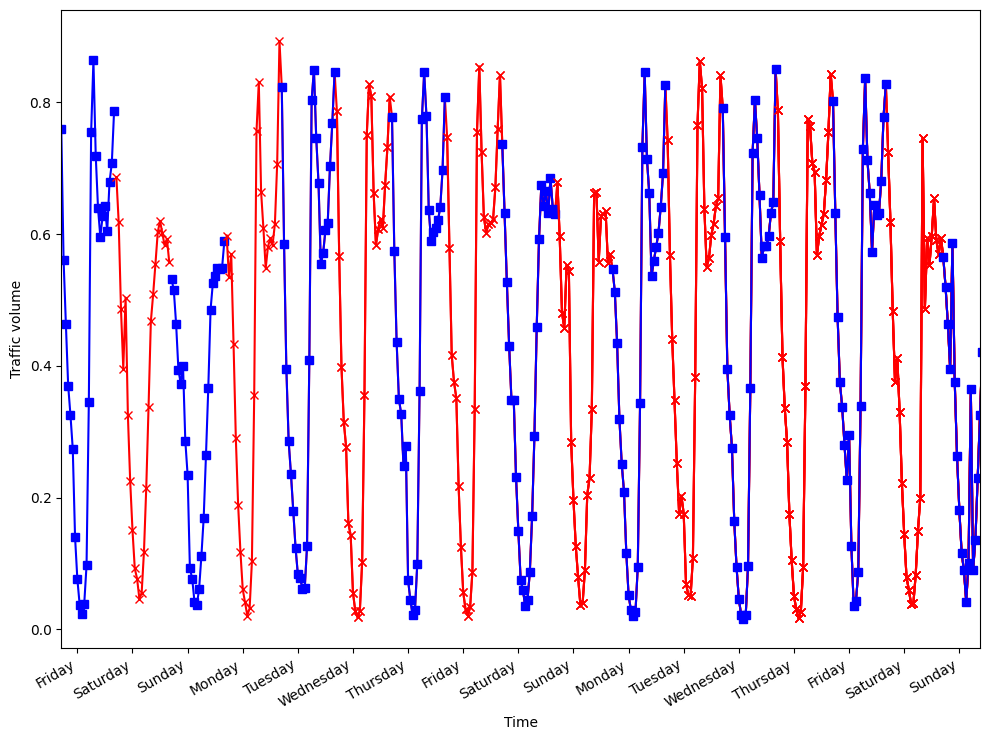

In [ ]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

### 13.1.2 Implementing the `DataWindow` class

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [ ]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0818


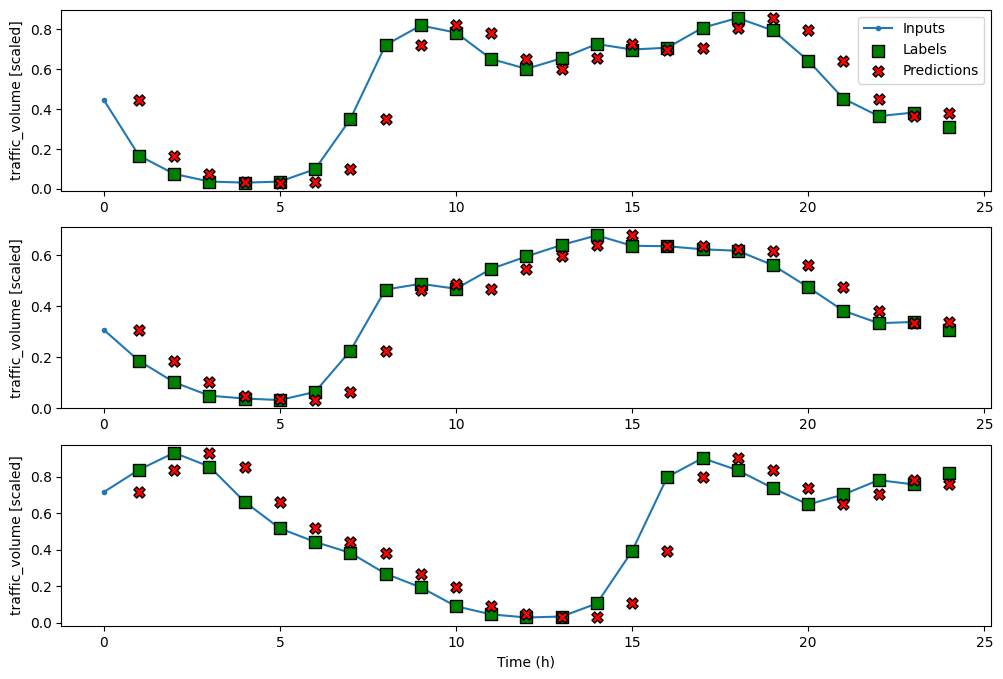

In [ ]:
wide_window.plot(baseline_last)

# plt.savefig('figures/CH13_F09_peixeiro.png', dpi=300)

In [ ]:
print(performance['Baseline - Last'][1])

0.08128398656845093


### 13.2.2 Multi-step baseline models

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1881 - mean_absolute_error: 0.3528


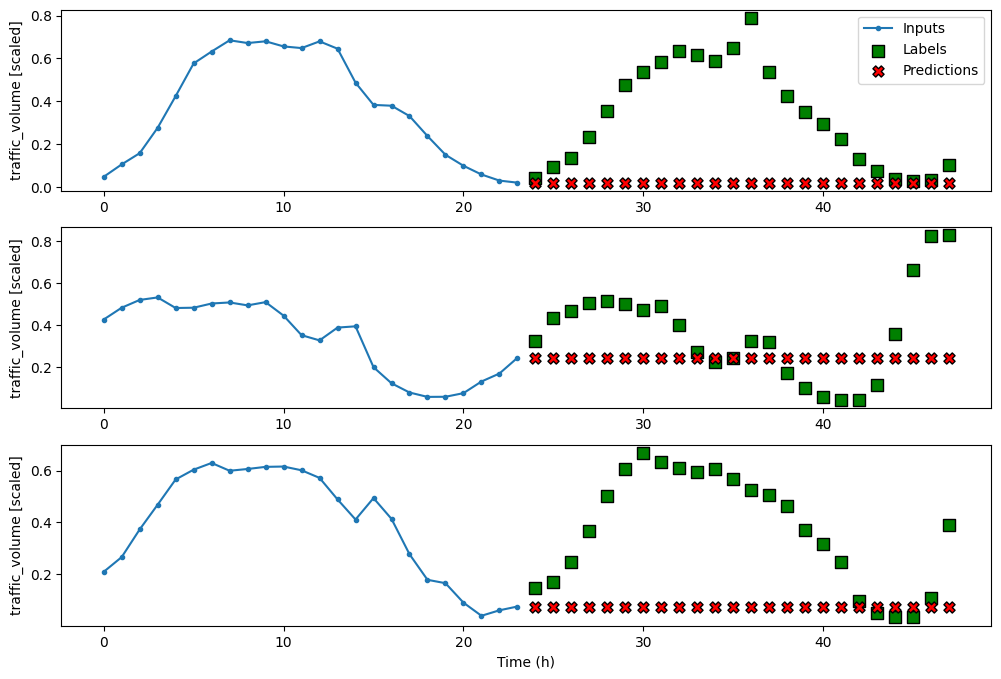

In [ ]:
multi_window.plot(ms_baseline_last)

In [ ]:
print(ms_performance['Baseline - Last'][1])

0.3472607433795929


#### Repeating the input sequence

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [ ]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2065 - mean_absolute_error: 0.3476


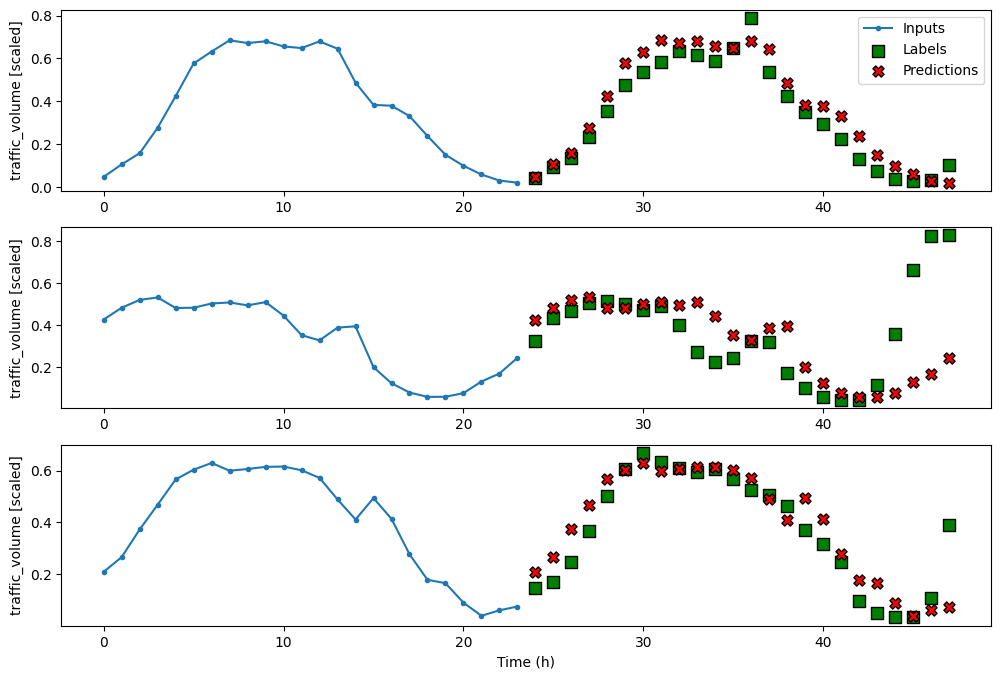

In [ ]:
multi_window.plot(ms_baseline_repeat)

In [ ]:
print(ms_performance['Baseline - Repeat'][1])

0.34127721190452576


### 13.2.3 Multi-output baseline model

In [ ]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [ ]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [ ]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


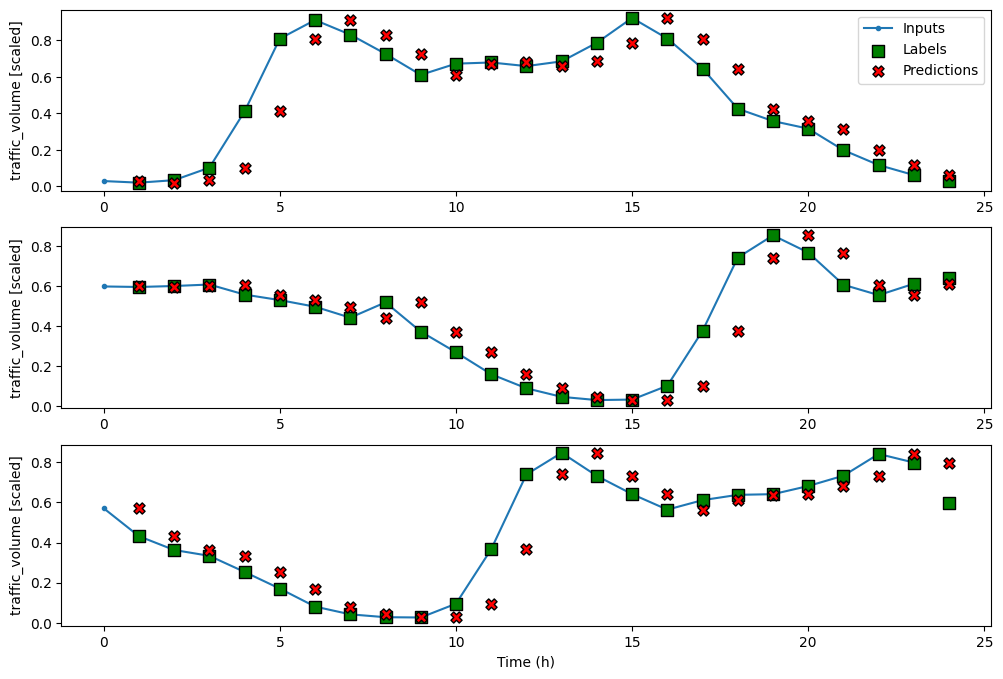

In [ ]:
mo_wide_window.plot(mo_baseline_last)

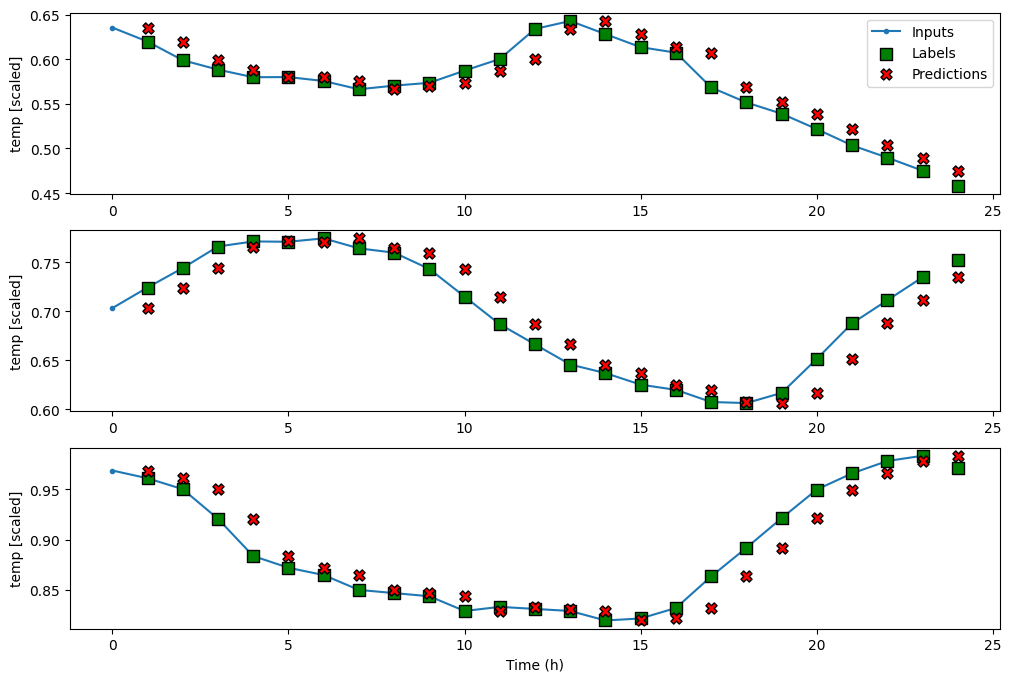

In [ ]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [ ]:
print(mo_performance['Baseline - Last'][1])

0.047106657177209854


# Chapter 14

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7838 - mean_absolute_error: 0.7602 - val_loss: 0.2225 - val_mean_absolute_error: 0.3806
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1822 - mean_absolute_error: 0.3506 - val_loss: 0.1236 - val_mean_absolute_error: 0.2904
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1089 - mean_absolute_error: 0.2711 - val_loss: 0.0722 - val_mean_absolute_error: 0.2159
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0630 - mean_absolute_error: 0.2000 - val_loss: 0.0411 - val_mean_absolute_error: 0.1553
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0365 - mean_absolute_error: 0.1460 - val_loss: 0.0245 - val_mean_absolute_error: 0.1148
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0221 - mean_absolute_error: 0.1097 - val_loss: 0.0166 - val_mean_absolute_error: 0.0920
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.0915 - v

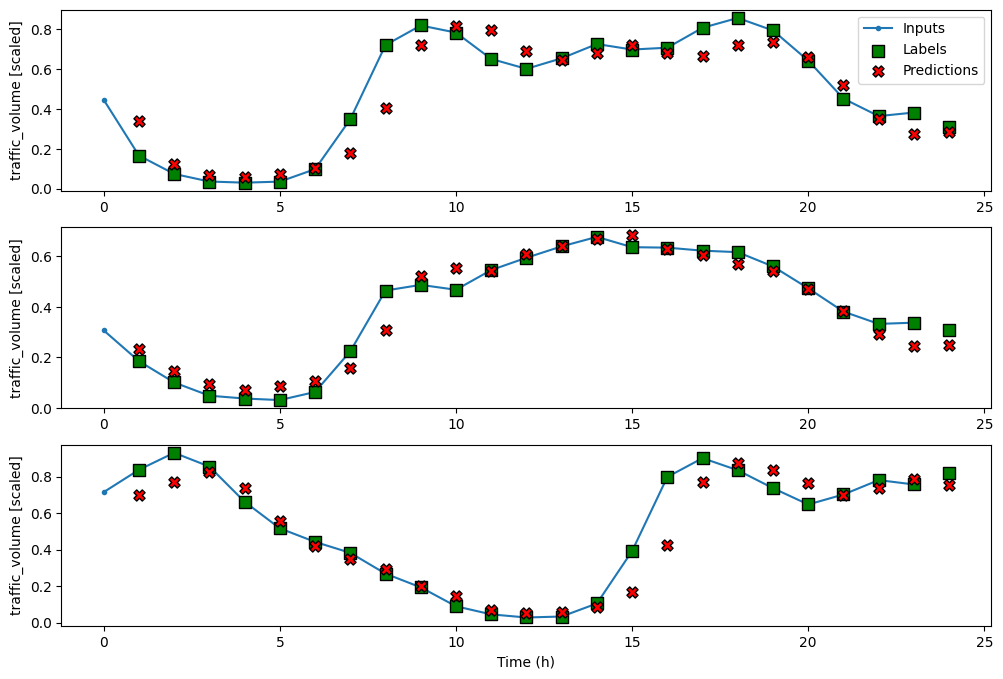

In [ ]:
wide_window.plot(linear)

### 14.1.2 Building a mutli-step linear model

In [ ]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1420 - mean_absolute_error: 0.3082 - val_loss: 0.0457 - val_mean_absolute_error: 0.1821
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0344 - mean_absolute_error: 0.1513 - val_loss: 0.0261 - val_mean_absolute_error: 0.1252
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0209 - mean_absolute_error: 0.1076 - val_loss: 0.0212 - val_mean_absolute_error: 0.1074
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0178 - mean_absolute_error: 0.0962 - val_loss: 0.0196 - val_mean_absolute_error: 0.1000
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0168 - mean_absolute_error: 0.0917 - val_loss: 0.0188 - val_mean_absolute_error: 0.0952
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0163 - mean_absolute_error: 0.0888 - val_loss: 0.0184 - val_mean_absolute_error: 0.0924
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0161 - mean_absolute_error: 0.0868 - 

### 14.1.3 Implementing a multi-output linear model

In [ ]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5683 - mean_absolute_error: 0.6501 - val_loss: 0.1855 - val_mean_absolute_error: 0.3608
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1437 - mean_absolute_error: 0.3177 - val_loss: 0.0888 - val_mean_absolute_error: 0.2519
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0728 - mean_absolute_error: 0.2247 - val_loss: 0.0470 - val_mean_absolute_error: 0.1787
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0382 - mean_absolute_error: 0.1578 - val_loss: 0.0253 - val_mean_absolute_error: 0.1273
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.1122 - val_loss: 0.0143 - val_mean_absolute_error: 0.0928
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0833 - val_loss: 0.0094 - val_mean_absolute_error: 0.0732
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0677 - 

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [ ]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0244 - mean_absolute_error: 0.0993 - val_loss: 0.0054 - val_mean_absolute_error: 0.0574
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0495 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0438 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0421 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0396 - val_loss: 0.0033 - val_mean_absolute_error: 0.0447
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0397 - val_loss: 0.0029 - val_mean_absolute_error: 0.0409
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0382 - v

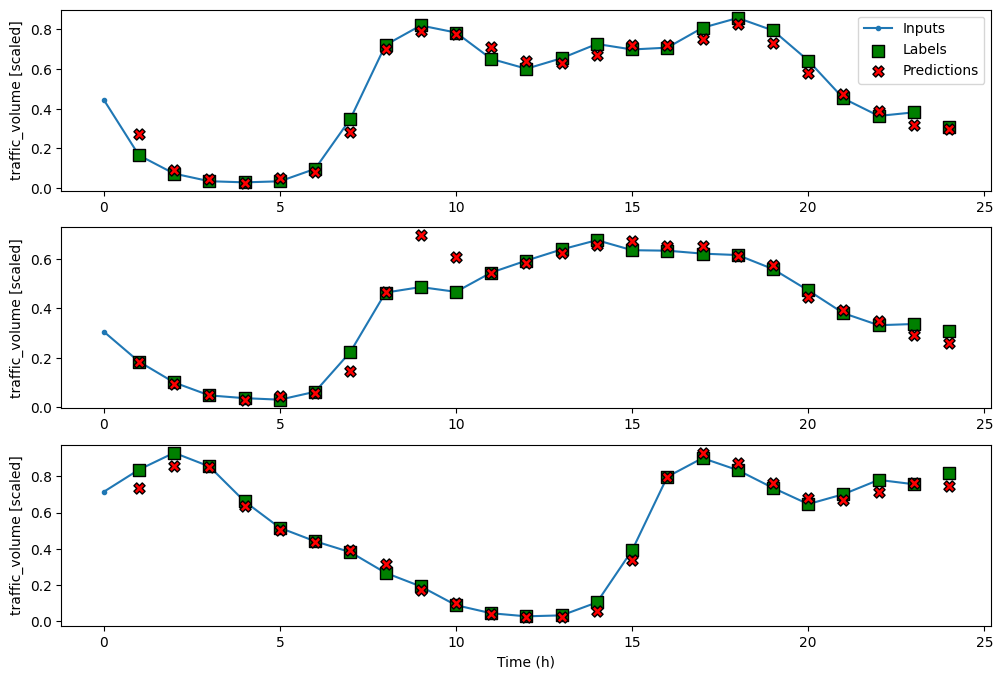

In [ ]:
wide_window.plot(dense)

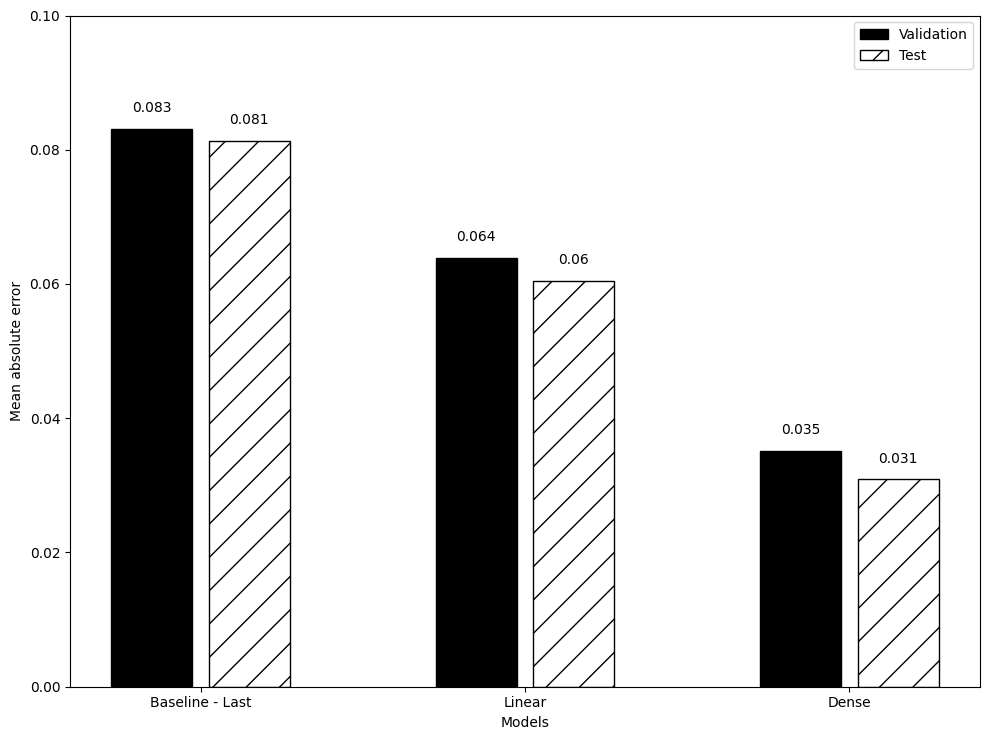

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### 14.2.2 Implementing a deep neural network as a multi-step model

In [ ]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0653 - mean_absolute_error: 0.1731 - val_loss: 0.0168 - val_mean_absolute_error: 0.0828
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0144 - mean_absolute_error: 0.0789 - val_loss: 0.0168 - val_mean_absolute_error: 0.0825
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0141 - mean_absolute_error: 0.0791 - val_loss: 0.0157 - val_mean_absolute_error: 0.0863
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0136 - mean_absolute_error: 0.0779 - val_loss: 0.0155 - val_mean_absolute_error: 0.0797
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0134 - mean_absolute_error: 0.0774 - val_loss: 0.0150 - val_mean_absolute_error: 0.0814
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0770 - val_loss: 0.0148 - val_mean_absolute_error: 0.0792
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - mean_absolute_error: 0.0769 -

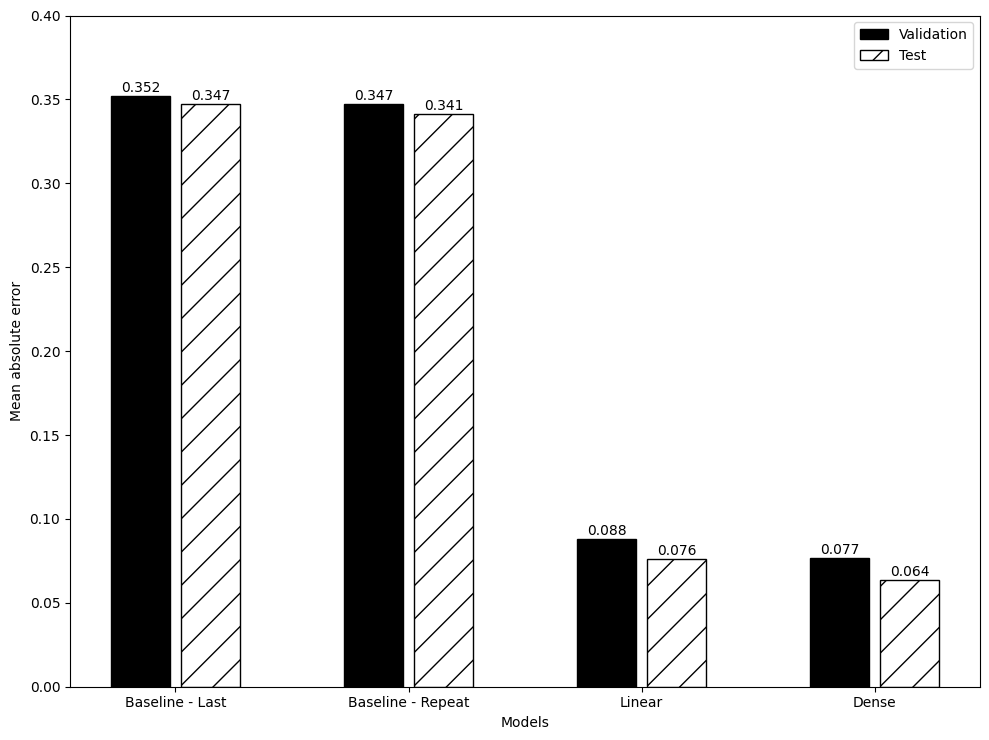

In [ ]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### 14.2.3 Implementing a deep neural network as a multi-output model

In [ ]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0438 - mean_absolute_error: 0.1277 - val_loss: 0.0026 - val_mean_absolute_error: 0.0333
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0021 - val_mean_absolute_error: 0.0297
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0298 - val_loss: 0.0017 - val_mean_absolute_error: 0.0268
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0286 - val_loss: 0.0017 - val_mean_absolute_error: 0.0262
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0274 - val_loss: 0.0016 - val_mean_absolute_error: 0.0257
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0276 - val_loss: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0263 - v

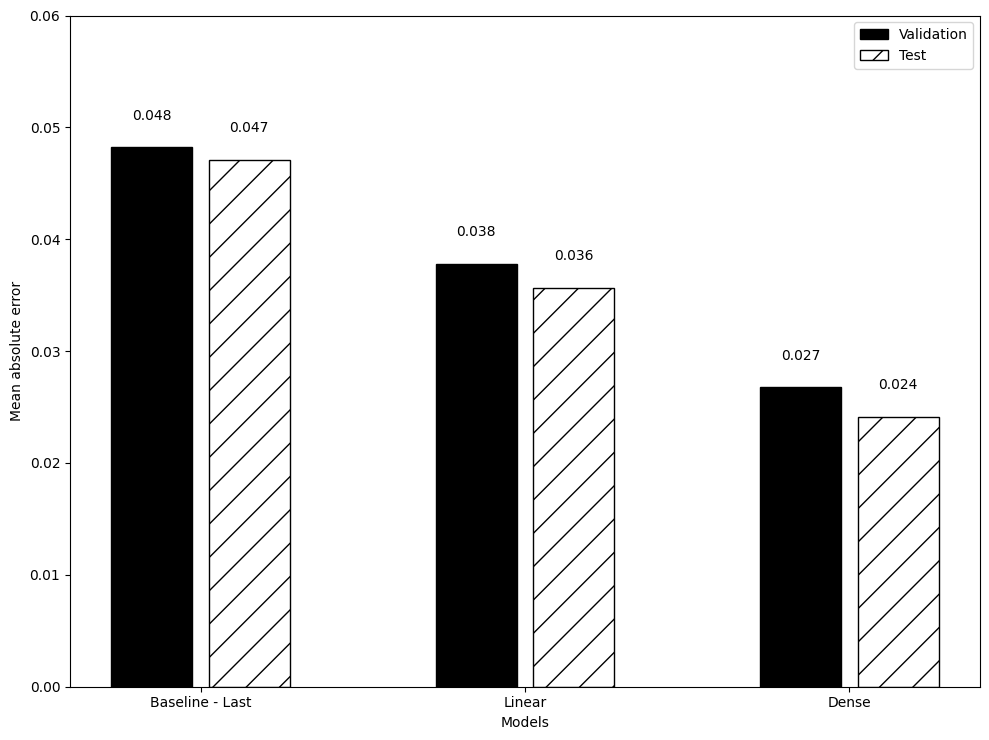

In [ ]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()